In [40]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error


In [42]:
# 2. Load Data
df = pd.read_csv("C:/Users/punit/OneDrive/Desktop/ACM-30Days/insurance.csv")
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [44]:
# 3.Initial Inspection
print("Data Info:")
df.info()

print("\nMissing Values:")
print(df.isnull().sum())

print("\nUnique Categorical Values:")
for col in df.select_dtypes('object'):
    print(f"{col} ➜", df[col].unique())


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB

Missing Values:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Unique Categorical Values:
sex ➜ ['female' 'male']
smoker ➜ ['yes' 'no']
region ➜ ['southwest' 'southeast' 'northwest' 'northeast']


In [46]:
# 4.Data Cleaning
# Clean categories
df['sex'] = df['sex'].str.strip().str.lower()
df['smoker'] = df['smoker'].str.strip().str.lower()
df['region'] = df['region'].str.strip().str.lower()

# Fill missing if any (optional, this dataset usually has no nulls)
df.fillna(df.median(numeric_only=True), inplace=True)


In [48]:
# 5.Outlier Detection + Removal 
# IQR-based outlier removal
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    before = df.shape[0]
    df = df[(df[col] >= lower) & (df[col] <= upper)]
    print(f"{col}: Removed {before - df.shape[0]} rows")
    return df

df = remove_outliers(df, 'bmi')
df = remove_outliers(df, 'charges')


bmi: Removed 9 rows
charges: Removed 138 rows


In [50]:
# 6.Encode Categorical Features
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)
print("Final columns after encoding:\n", df_encoded.columns.tolist())


Final columns after encoding:
 ['age', 'bmi', 'children', 'charges', 'sex_male', 'smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest']


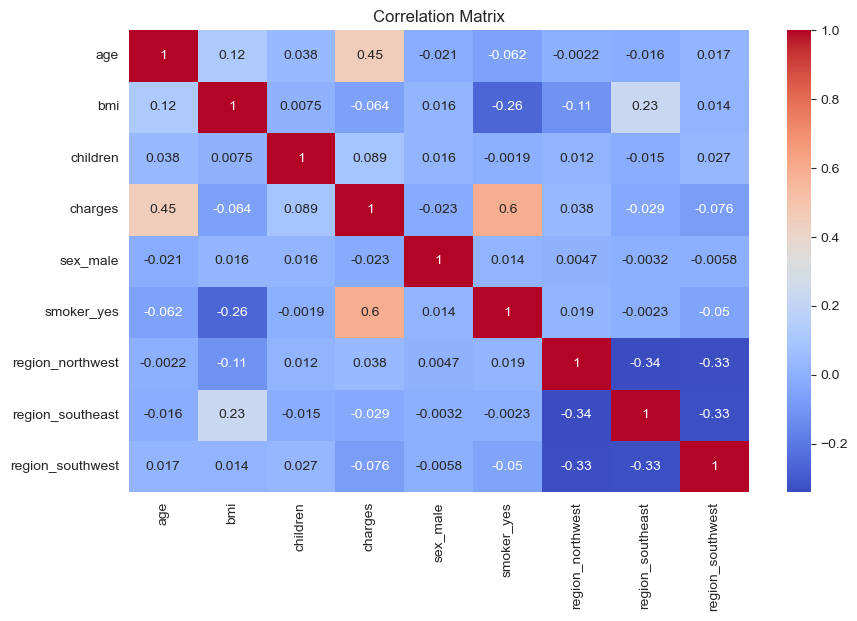

In [52]:
# 7.EDA – Correlation Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


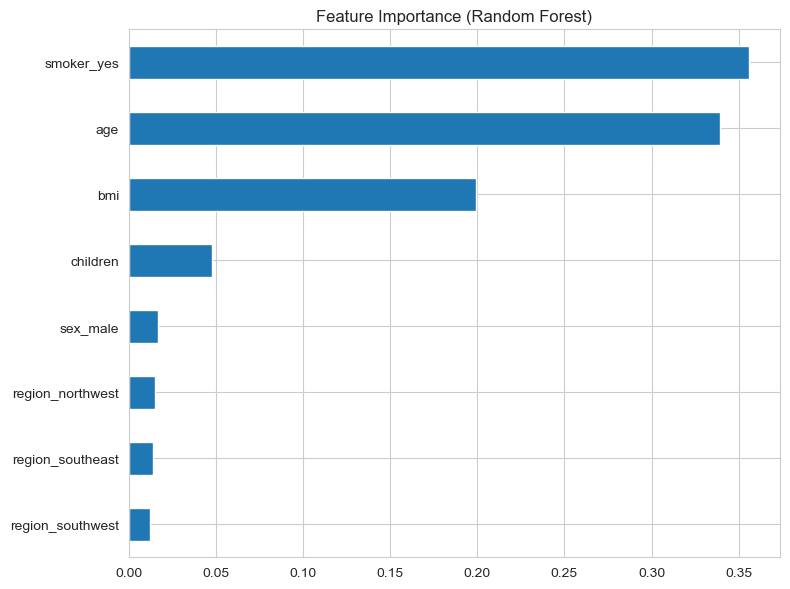

In [54]:
# 8: Feature Importance (Random Forest)
X = df_encoded.drop("charges", axis=1)
y = df_encoded["charges"]

rf_temp = RandomForestRegressor(random_state=42)
rf_temp.fit(X, y)

imp = pd.Series(rf_temp.feature_importances_, index=X.columns)
imp.sort_values().plot(kind='barh', title="Feature Importance (Random Forest)", figsize=(8,6))
plt.tight_layout()
plt.show()


In [56]:
# 9: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [58]:
# 10: Baseline Model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print(" Linear Regression Results (Cleaned Data):")
print("R² Score:", round(r2_score(y_test, y_pred_lr), 3))
print("MSE:", round(mean_squared_error(y_test, y_pred_lr), 2))


 Linear Regression Results (Cleaned Data):
R² Score: 0.633
MSE: 19877696.62


In [60]:
# 11: Final Model
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print(" Random Forest Results (Cleaned Data):")
print(" R² Score:", round(r2_score(y_test, y_pred_rf), 3))
print(" MSE:", round(mean_squared_error(y_test, y_pred_rf), 2))


 Random Forest Results (Cleaned Data):
 R² Score: 0.626
 MSE: 20224742.74


In [62]:
#12: Final Comparison Table
compare_df = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "R² Score": [r2_score(y_test, y_pred_lr), r2_score(y_test, y_pred_rf)],
    "MSE": [mean_squared_error(y_test, y_pred_lr), mean_squared_error(y_test, y_pred_rf)]
})

print("\n Final Comparison:")
display(compare_df.round(3))



 Final Comparison:


,Model,R² Score,MSE
0,Linear Regression,0.633,1.987770e+07
1,Random Forest,0.626,2.022474e+07
